In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 17 20:42:36 2022

@author: Sonny
"""

# Importing libraries that I think we might need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
#from fbprophet import Prophet
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Ryan's PC path
#path = "C://Users//ryany//OneDrive//Desktop//SandwichData//"

# Ryan's MAC Path
#path = "/Users/931.ryoneshige/Desktop/SandwichData/"

E:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
E:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
# Setting up a filenames list that everyone should be able to use
filenames = [
    "updated_WEEKLY_SALES_10STORES"
    , "AppWichStoreAttributes"
    , "county_crime"
    , "county_demographic"
    , "county_employment"
    , "WEEKLY_WEATHER"
             ]

# Creating a list to store dfs
df_list = []

# Iterating through the filenames to read in dfs
for i in range(len(filenames)):
    temp_df = pd.read_csv(path+filenames[i]+".csv")
    df_list.append(temp_df)

# Storing dfs
sales = df_list[0]
store = df_list[1]
crime = df_list[2]
county = df_list[3]
employment = df_list[4]
weather = df_list[5]

In [2]:
# Sonny's data load
sales = pd.read_csv("updated_WEEKLY_SALES_10STORES.csv")
weather = pd.read_csv("WEEKLY_WEATHER.csv")
store = pd.read_csv("AppWichStoreAttributes.csv")
crime = pd.read_csv("county_crime.csv")
county = pd.read_csv("county_demographic.csv")
employment = pd.read_csv("county_employment.csv")

In [3]:
# Creating a dataframe to see which items were sold the most at each store
item_sales_by_store = sales.iloc[:,[0,1,2,4]].groupby(['Store_num','INV_NUMBER', 'Description']).sum()
item_sales_by_store = item_sales_by_store.sort_values(by = ['Store_num','Sold'], ascending = [True, False])

# Looking at the top 5 sellers per store
print(item_sales_by_store.groupby('Store_num').head(5))

# Looking at just store 9, because it was the only one without the 
# mini meatball val meal in the top 5
print(item_sales_by_store.loc[[9],:,:].head(10))
# Mini meatball val meal not even in top 10

                                                 Sold
Store_num INV_NUMBER Description                     
2         5014       CHIPS                      37890
          11519      21OZ DRINK                 19916
          4916       1 COOKIE                   13995
          11520      30OZ DRINK                 11980
          1651       REGULAR SAVORY TURKEY      11297
5         5014       CHIPS                      15235
          11519      21OZ DRINK                  7841
          4916       1 COOKIE                    5707
          4917       3 COOKIES                   3960
          1651       REGULAR SAVORY TURKEY       3847
7         5014       CHIPS                      27148
          11519      21OZ DRINK                 12850
          4916       1 COOKIE                    9330
          1651       REGULAR SAVORY TURKEY       7869
          1611       REGULAR HONEY MUSTARD HAM   6234
9         5014       CHIPS                      24646
          11519      21OZ DR

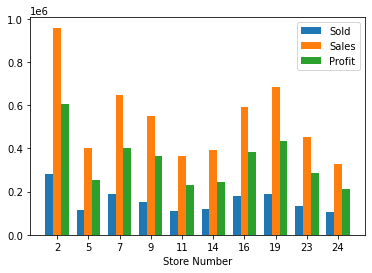

In [4]:
# Creating a dataframe to look at sales by store
store_sales = sales.iloc[:,[1,4,6,12]].groupby('Store_num').sum()

# Creating a plot to show num items sold, total sales, and total profit by store
N = 10
ind = np.arange(N)
width = 0.25

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x = ind, height = store_sales.Sold, width = width, label = 'Sold')
ax.bar(x = ind+width, height = store_sales.Sales, width = width, label = 'Sales')
ax.bar(x = ind+2*width, height = store_sales.Profit, width = width, label = 'Profit')

ax.set_xlabel('Store Number')
ax.set_xticks(ind + width)
ax.set_xticklabels(['2','5','7','9','11','14','16','19','23','24'])

plt.legend()
plt.show()

In [7]:
# Looking at avg sales and avg profit by store
store_sales['avg_sales'] = store_sales.Sales/store_sales.Sold
store_sales['avg_profit'] = store_sales.Profit/store_sales.Sold

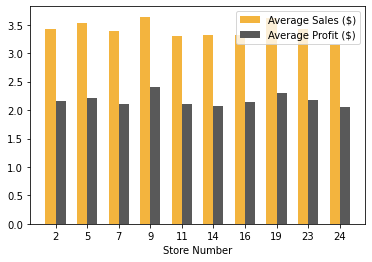

In [8]:
# Creating a plot to show avg sales and avg profit by store
N = 10
ind = np.arange(N)
width = 0.32

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x = ind, height = store_sales.avg_sales, width = width, label = 'Average Sales ($)', color = '#f3b43e')
ax.bar(x = ind+width, height = store_sales.avg_profit, width = width, label = 'Average Profit ($)', color = '#595959')

ax.set_xlabel('Store Number')
ax.set_xticks(ind + width/2)
ax.set_xticklabels(['2','5','7','9','11','14','16','19','23','24'])

plt.legend(loc = 'best')
plt.show()

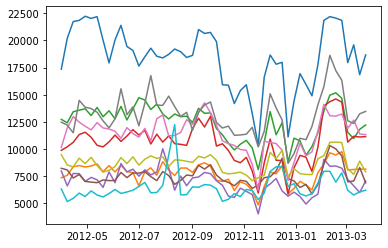

In [9]:
# Creating a store dictionary
store_nums = [2, 5, 7, 9, 11, 14, 16, 19, 23, 24]

stores_list = []

for num in store_nums:
    stores_list.append(sales[sales.Store_num == num])

store_dict = {f'Store{store_nums[i]}':stores_list[i] for i in range(len(store_nums))}


# Creating a function to convert the dictionary into time series data
def to_time_ser(dic):
    df_list = []
    for df in dic.values():
        temp_df = df.copy()
        temp_df.Date = pd.to_datetime(df.Date)
        temp_df = temp_df[['Sales', 'Date']].groupby('Date').sum()
        df_list.append(temp_df)
    df_dict = {list(dic.keys())[i]:df_list[i] for i in range(len(dic))}
    
    return df_dict


# Running the to_time_ser function on the store dictionary to set up for plotting
ts_store_dict = to_time_ser(store_dict)

# Plotting time series plots 
for df in ts_store_dict.values():
    plt.plot(df)
plt.show()

In [6]:
# Combing the sales, stores and crime data
crime_added = pd.merge(store, crime, left_on='Store_County', right_on = 'County_Name')
mass_sales = pd.merge(sales, crime_added,left_on='Store_num', right_on = 'Store_Num' )

<ipython-input-8-cd0de13976da>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = masscorr.corr()


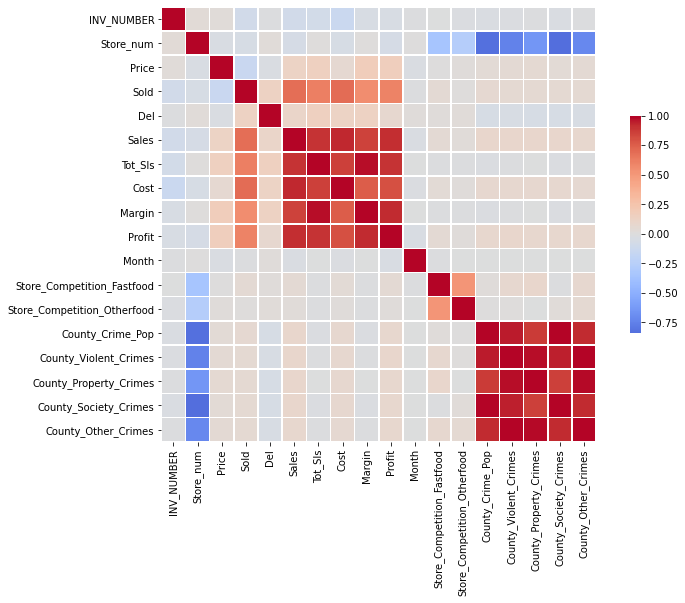

In [8]:
# Correlation of sales
masscorr = mass_sales.drop(['Store_Num', 'Year', 'Day', 'Unit_Cost', 'Cost_Percent'
                            , 'County_Total_Crimes'
                           , 'County_Property_Rate', 'County_Society_Rate', 'County_Violent_Rate'
                           , 'County_Other_Rate', 'County_Total_Crime_Rate'], axis=1)
corr = masscorr.corr()

# Generate a mask for the upper triangle
#mask = np.zeros_like(corr, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap= 'coolwarm', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

<ipython-input-12-04f430e8fae5>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = masscorr.corr()
<ipython-input-12-04f430e8fae5>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


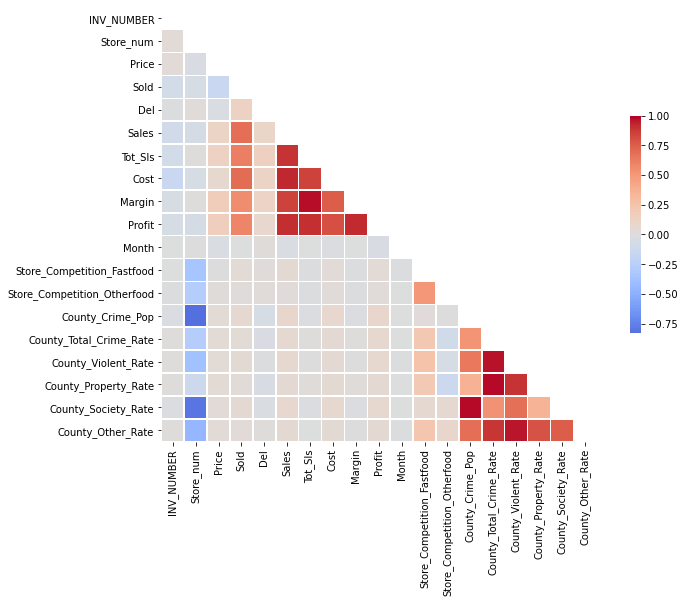

In [12]:
# diffevert correlation with the rates instead
masscorr = mass_sales.drop(['Store_Num', 'Year', 'Day', 'Unit_Cost', 'Cost_Percent'
                            , 'County_Total_Crimes'
                           , 'County_Property_Crimes', 'County_Society_Crimes', 'County_Violent_Crimes'
                           , 'County_Other_Crimes'], axis=1)
corr = masscorr.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(12,8))
sns.heatmap(corr, mask=mask, cmap= 'coolwarm', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

<ipython-input-13-834f9e9e2e4f>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = masscorr.corr()
<ipython-input-13-834f9e9e2e4f>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


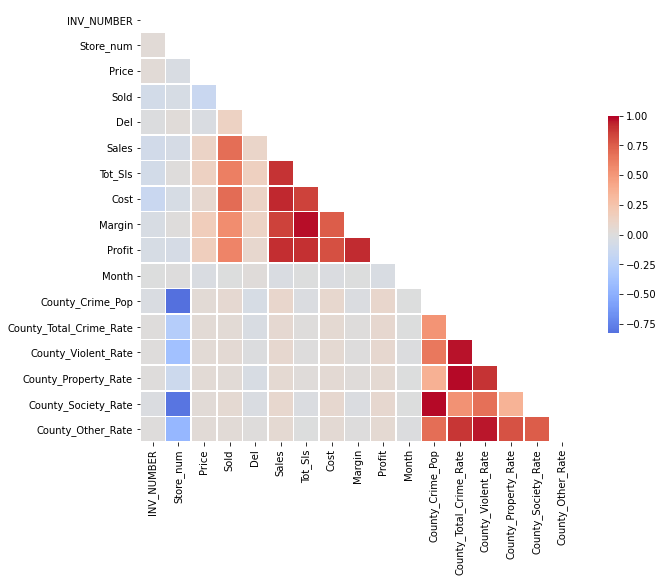

In [13]:
# correlation view 3 removing the competition from teh view
masscorr = mass_sales.drop(['Store_Num', 'Year', 'Day', 'Unit_Cost', 'Cost_Percent'
                            , 'Store_Competition_Fastfood', 'Store_Competition_Otherfood','County_Total_Crimes'
                           , 'County_Property_Crimes', 'County_Society_Crimes', 'County_Violent_Crimes'
                           , 'County_Other_Crimes'], axis=1)
corr = masscorr.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(12,8))
sns.heatmap(corr, mask=mask, cmap= 'coolwarm', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

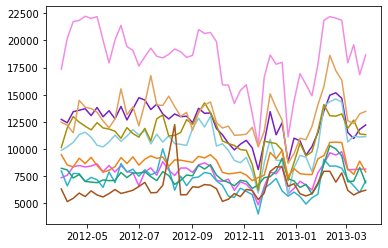

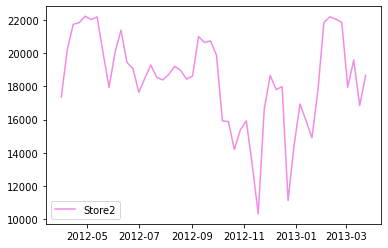

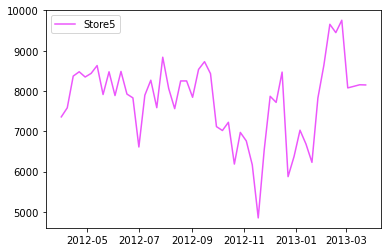

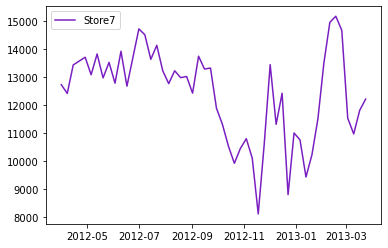

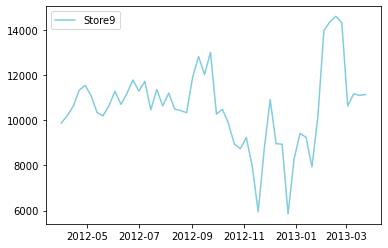

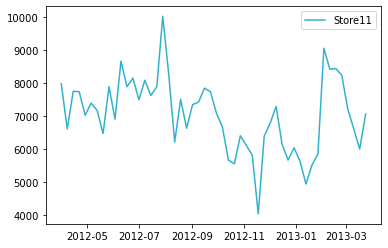

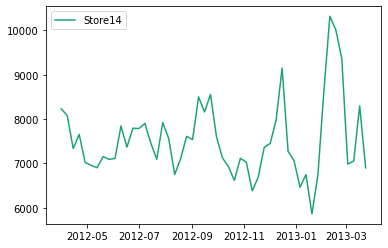

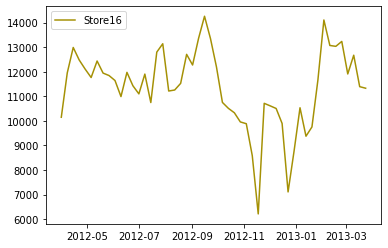

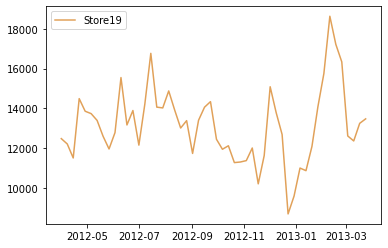

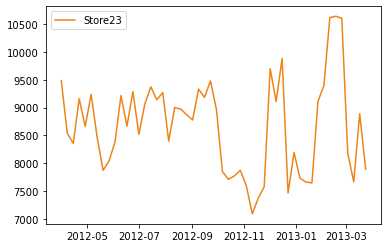

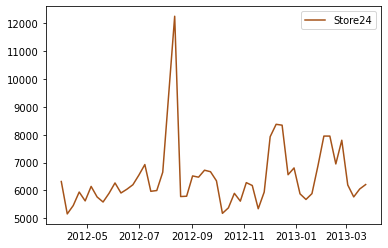

In [14]:
# Adding labels to individual plots and coloring the plots
store_names = [key for key in ts_store_dict.keys()]

ts_stores = [val for val in ts_store_dict.values()]

colors = ['#f28be5','#ec56fc','#791ec1','#81ccdf','#30b2ce'
          ,'#1ca377','#a59105','#e1a159','#ec8417','#a55319']

# Fixing the time series plots to use specific colors
for i in range(len(ts_stores)):
    plt.plot(ts_stores[i], color = colors[i])
plt.show()

# Plotting individaul stores with the same colors used in the group plot
for i in range(len(ts_stores)):
    plt.plot(ts_stores[i], label = store_names[i], color = colors[i])
    plt.legend()
    plt.show()

In [17]:
# Creating a function to evaluate an ARIMA model for order (p,d,q)
def get_aic(X, p, d, q):
    model = ARIMA(X, order=(p,d,q))
    model_aic = model.fit().aic
    return model_aic

# Creating a function to forcast a number of weeks with an "optimized" ARIMA model
def create_opt_model_forecast(dataset, p_values, d_values, q_values, weeks):
    dataset = dataset.astype('float32')
    best_score = float("inf")
    P = None
    D = None
    Q = None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    AIC = get_aic(dataset, p, d, q)
                    if AIC < best_score:
                        best_score = AIC
                        P = p
                        D = d
                        Q = q
                        print('p='+str(p)+',d='+str(d)+',q='+str(q)+' AIC='+str(AIC))
                except:
                    continue
    results_dict = {'p':P, 'd':D, 'q':Q, 'AIC':np.round(best_score,2)}
    print(results_dict)
    opt_model = ARIMA(dataset, order = (results_dict['p'], results_dict['d'], results_dict['q']))
    opt_model_forecast = opt_model.fit().forecast(steps = weeks)
    return opt_model_forecast


# Setting the ranges for p, d, and q
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")

In [18]:
# Creating train and test sets for each store to test the models
stores_train  = []
stores_test = []

for i in range(len(ts_stores)):
    temp_train = ts_stores[i][ts_stores[i].index < '2013']
    temp_test = ts_stores[i][ts_stores[i].index >= '2013']
    stores_train.append(temp_train)
    stores_test.append(temp_test)

In [19]:
# Creating predictions for each store for 12 weeks
stores_predictions = []

for i in range(len(stores_train)):
    temp_pred = create_opt_model_forecast(stores_train[i].values, p_values, d_values, q_values, 12)
    temp_df = pd.DataFrame({'Predicted':temp_pred}, index = stores_test[i].index)
    temp_df2 = pd.concat([stores_test[i], temp_df], axis = 1)
    stores_predictions.append(temp_df2)

p=0,d=0,q=0 AIC=752.9728073231219
p=0,d=0,q=1 AIC=730.2140784243959
p=0,d=0,q=3 AIC=727.7519529217568
p=0,d=0,q=4 AIC=726.9564501669304
p=0,d=1,q=0 AIC=711.1573433067226
p=0,d=3,q=1 AIC=708.4162814118171
p=0,d=3,q=2 AIC=696.7284512028972
p=0,d=4,q=3 AIC=693.1600383370252
{'p': 0, 'd': 4, 'q': 3, 'AIC': 693.16}
p=0,d=0,q=0 AIC=661.7096472543659
p=0,d=0,q=1 AIC=652.4498945548598
p=0,d=1,q=0 AIC=638.2407983925266
p=0,d=1,q=1 AIC=638.1188276299496
p=0,d=2,q=1 AIC=635.7721808321392
p=0,d=3,q=2 AIC=625.8775443231984
p=0,d=4,q=3 AIC=621.1730943169994
{'p': 0, 'd': 4, 'q': 3, 'AIC': 621.17}
p=0,d=0,q=0 AIC=704.4656380894766
p=0,d=0,q=1 AIC=692.6843595965343
p=0,d=0,q=2 AIC=685.3413321221145
p=0,d=1,q=0 AIC=668.1167952747747
p=0,d=1,q=1 AIC=666.6394075988371
p=0,d=3,q=2 AIC=655.4685509474789
p=0,d=4,q=3 AIC=651.3318532078238
p=1,d=4,q=2 AIC=650.7362715794876
{'p': 1, 'd': 4, 'q': 2, 'AIC': 650.74}
p=0,d=0,q=0 AIC=703.7764476391153
p=0,d=0,q=1 AIC=689.6993560012397
p=0,d=0,q=2 AIC=685.4999546029

In [22]:
# Attempting to fix the stores with strange results
retry_stores = [3,8]
retry_orders = {3:(0,4,3)
#                , 2:(0,4,3)
                , 8:(0,4,3)
                }

# Dropping the old predictions and insering new ones
for i in retry_stores:
    temp_model = ARIMA(stores_train[i].values.astype('float32'), order = retry_orders[i])
    temp_pred = temp_model.fit().forecast(steps = 12)
    temp_df = pd.DataFrame({'Predicted':temp_pred}, index = stores_test[i].index)
    stores_predictions[i] = stores_predictions[i].drop('Predicted', axis = 1)
    stores_predictions[i] = pd.concat([stores_predictions[i], temp_df], axis = 1)

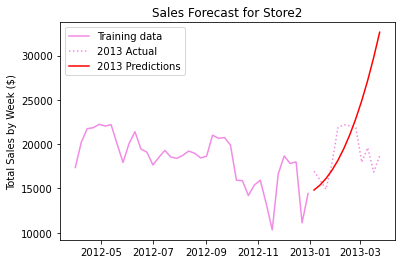

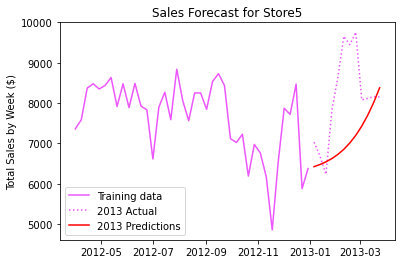

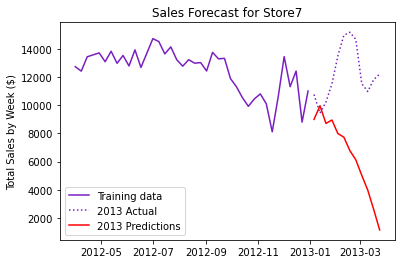

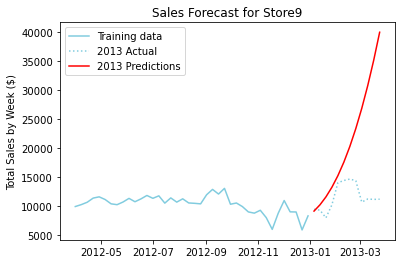

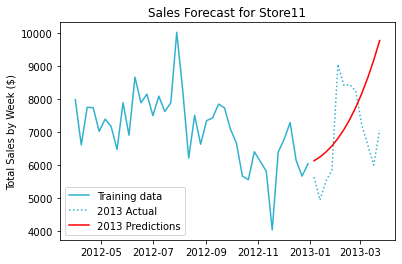

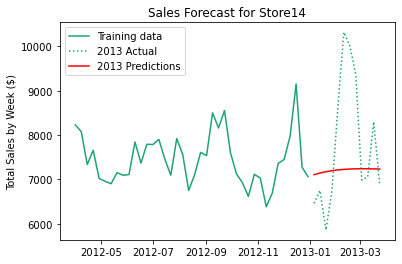

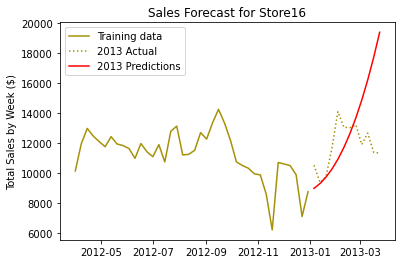

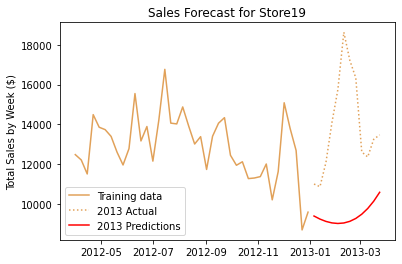

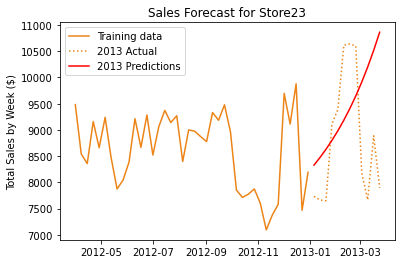

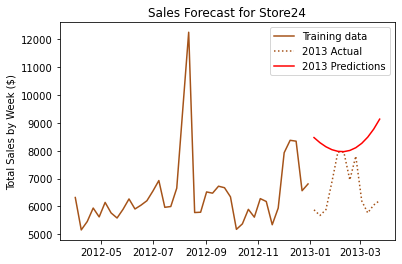

In [23]:
# Looping through the dataframes to plot the data against the predictions
for i in range(len(stores_predictions)):
    plt.plot(stores_train[i].index
             , stores_train[i].values
             , label = 'Training data'
             , color = colors[i])
    plt.plot(stores_predictions[i].index
             , stores_predictions[i].iloc[:,[0]].values
             , label = '2013 Actual'
             , linestyle = ':'
             , color = colors[i])
    plt.plot(stores_predictions[i].index
             , stores_predictions[i].Predicted.values
             , label = '2013 Predictions'
             , color = 'red')
    plt.ylabel('Total Sales by Week ($)')
    plt.title(f'Sales Forecast for {store_names[i]}')
    plt.legend()
    plt.show()

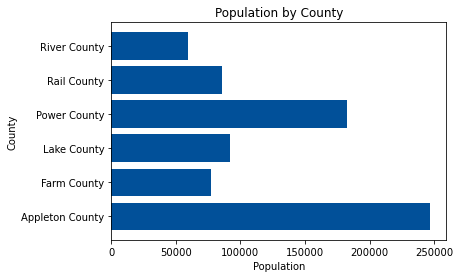

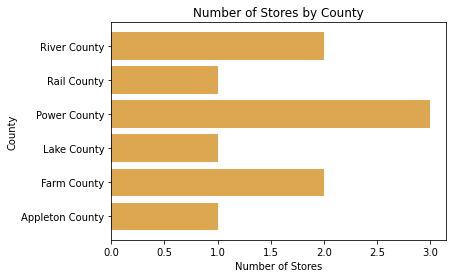

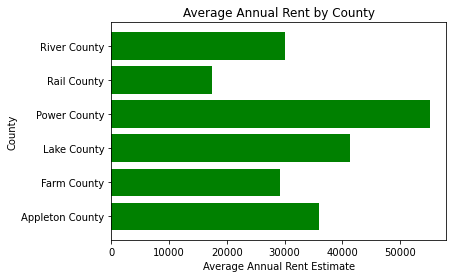

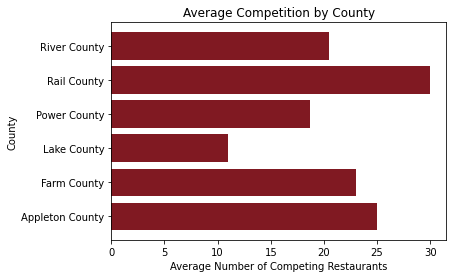

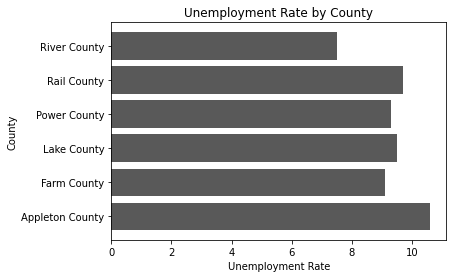

In [24]:
############### Creating some EDA plots #####################################

# Creating a plot to show population by county
N2 = 6
ind2 = np.arange(N2)

plt.barh(y = ind2
         , width = county.County_Total_Census_Pop
         , tick_label = county.County_Name
         , color = '#015099')
plt.xlabel('Population')
plt.ylabel('County')
plt.title('Population by County')
plt.show()


# Creating a plot to show number of stores by county
plt.barh(y = ind2
         , width = store.iloc[:,[1,3]].groupby('Store_County').count().Store_Num
         , tick_label = store.iloc[:,[1,3]].groupby('Store_County').count().index
         , color = '#dda650')
plt.xlabel('Number of Stores')
plt.ylabel('County')
plt.title('Number of Stores by County')
plt.show()


# Cleaning the rent estimate data before plotting
for i in range(len(store.Annual_Rent_Estimate)):
    store.Annual_Rent_Estimate[i] = int(store.Annual_Rent_Estimate[i].replace(',',''))


# Creating a plot to show average annual rent by county
plt.barh(y = ind2
         , width = store.iloc[:,[3,13]].groupby('Store_County').mean().Annual_Rent_Estimate
         , tick_label = store.iloc[:,[3,13]].groupby('Store_County').mean().index
         , color = 'green')
plt.xlabel('Average Annual Rent Estimate')
plt.ylabel('County')
plt.title('Average Annual Rent by County')
plt.show()


# Adding a Total Competition column to the store df to plot
store['Total_Competition'] = store.Store_Competition_Fastfood + store.Store_Competition_Otherfood

# Creating a plot to show average competition by county
plt.barh(y = ind2
         , width = store.iloc[:,[3,14]].groupby('Store_County').mean().Total_Competition
         , tick_label = store.iloc[:,[3,14]].groupby('Store_County').mean().index
         , color = '#801922')
plt.xlabel('Average Number of Competing Restaurants')
plt.ylabel('County')
plt.title('Average Competition by County')
plt.show()


# Creating a plot to show unemployment rate by county
plt.barh(y = ind2
         , width = employment.County_Unemployment_Rate
         , tick_label = employment.County_Name
         , color = '#595959')
plt.xlabel('Unemployment Rate')
plt.ylabel('County')
plt.title('Unemployment Rate by County')
plt.show()

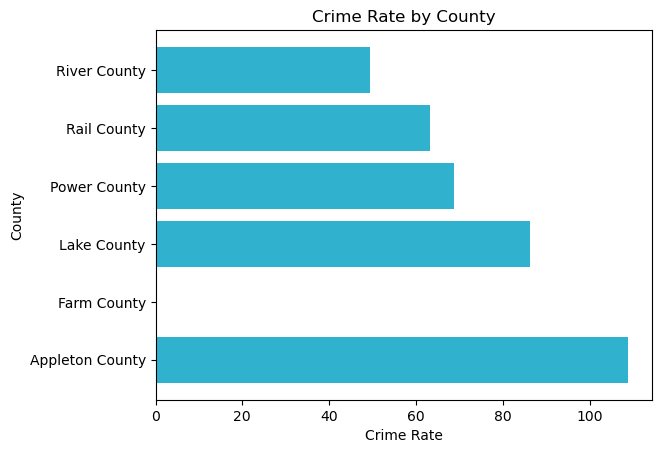

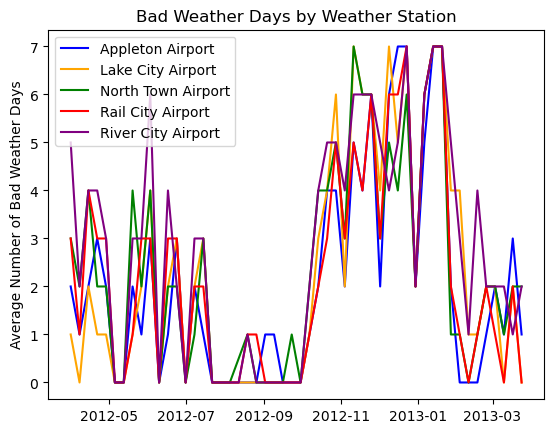

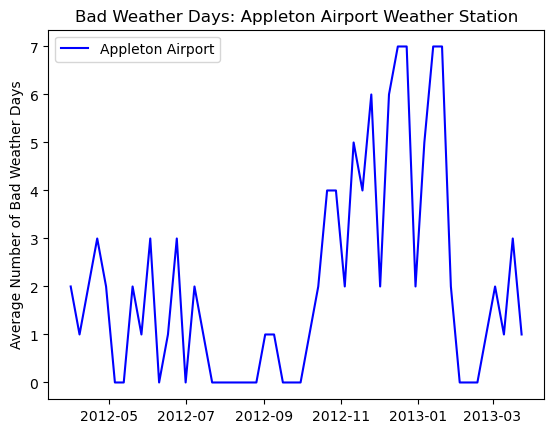

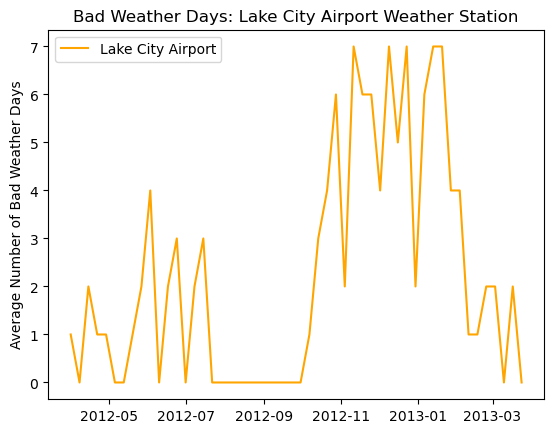

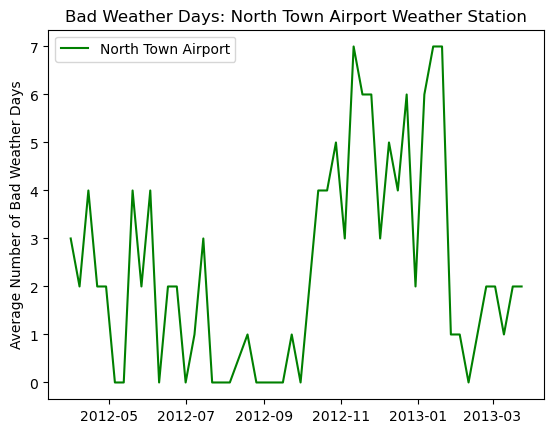

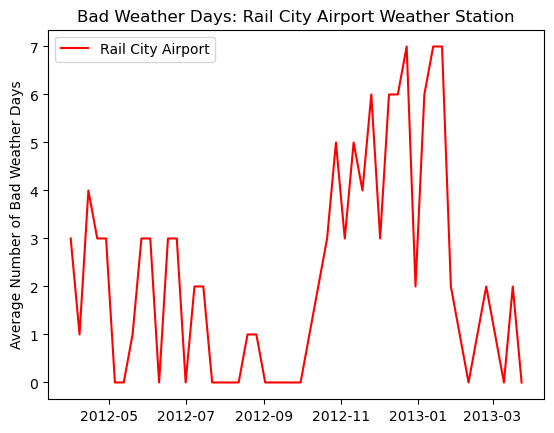

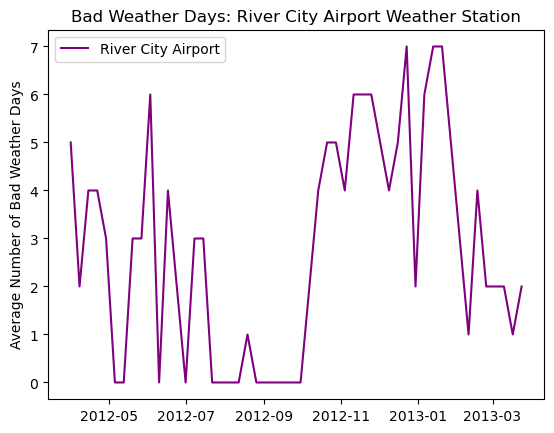

In [21]:
################## More EDA Plots ###################################################

# Creating a plot to show crime rate by county
plt.barh(y = ind2
         , width = crime.County_Total_Crime_Rate
         , tick_label = employment.County_Name
         , color = '#30b2ce')
plt.xlabel('Crime Rate')
plt.ylabel('County')
plt.title('Crime Rate by County')
plt.show()

# Cleaning up weather date in order to plot
weather['Weather_Date'] = pd.to_datetime(weather.Weather_Date, dayfirst = True)

# Creating dfs to store average number of bad weather days by county
weather_stations = weather.Weather_Station.unique()

bad_weather_dfs = []

for station in weather_stations:
    bad_weather_dfs.append(weather[weather.Weather_Station == station].iloc[:,[1,14]].groupby('Weather_Date').mean())
    

# Plotting average bad weather days by county
colors5 = ['blue', 'orange', 'green', 'red', 'purple']

for i in range(len(weather_stations)):
    plt.plot(bad_weather_dfs[i], label = weather_stations[i], color = colors5[i])
    plt.legend()
plt.ylabel('Average Number of Bad Weather Days')
plt.title('Bad Weather Days by Weather Station')
plt.show()

# Creating individual plots for average bad weather days by county
for i in range(len(weather_stations)):
    plt.plot(bad_weather_dfs[i], label = weather_stations[i], color = colors5[i])
    plt.ylabel('Average Number of Bad Weather Days')
    plt.title(f'Bad Weather Days: {weather_stations[i]} Weather Station')
    plt.legend()
    plt.show()

In [22]:
################ Creating Univariate Prophet models #########################

# Creating a df to set up profit by county
profit = sales[['Store_num', 'Profit', 'Date']]

profit.Date = pd.to_datetime(profit.Date)

profit_wCounty = profit.merge(store[['Store_Num', 'Store_County']]
                              , how = 'left'
                              , left_on = 'Store_num'
                              , right_on = 'Store_Num')

profit_wCounty.drop(['Store_num','Store_Num'], axis = 1, inplace = True)


# Creating dfs to separate each county
powerProfit = profit_wCounty[profit_wCounty.Store_County == 'Power County']
appletonProfit = profit_wCounty[profit_wCounty.Store_County == 'Appleton County']
riverProfit = profit_wCounty[profit_wCounty.Store_County == 'River County']
railProfit = profit_wCounty[profit_wCounty.Store_County == 'Rail County']
lakeProfit = profit_wCounty[profit_wCounty.Store_County == 'Lake County']
farmProfit = profit_wCounty[profit_wCounty.Store_County == 'Farm County']

In [23]:
# Creating a list of the county dfs to loop through
profit_dfs = [powerProfit, appletonProfit, riverProfit, railProfit, lakeProfit, farmProfit]

county_names = ['Power County','Appleton County','River County','Rail County','Lake County','Farm County']


# Preparing the profit dfs to be fit to the Prophet models
profit_summ_dfs = []
for df in profit_dfs:
    temp_df = df.drop(['Store_County'], axis = 1)
    temp_df = temp_df.groupby('Date').sum()
    temp_df = temp_df.reset_index()
    temp_df = temp_df.rename(columns = {'Date':'ds',
                                        'Profit':'y'})
    profit_summ_dfs.append(temp_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


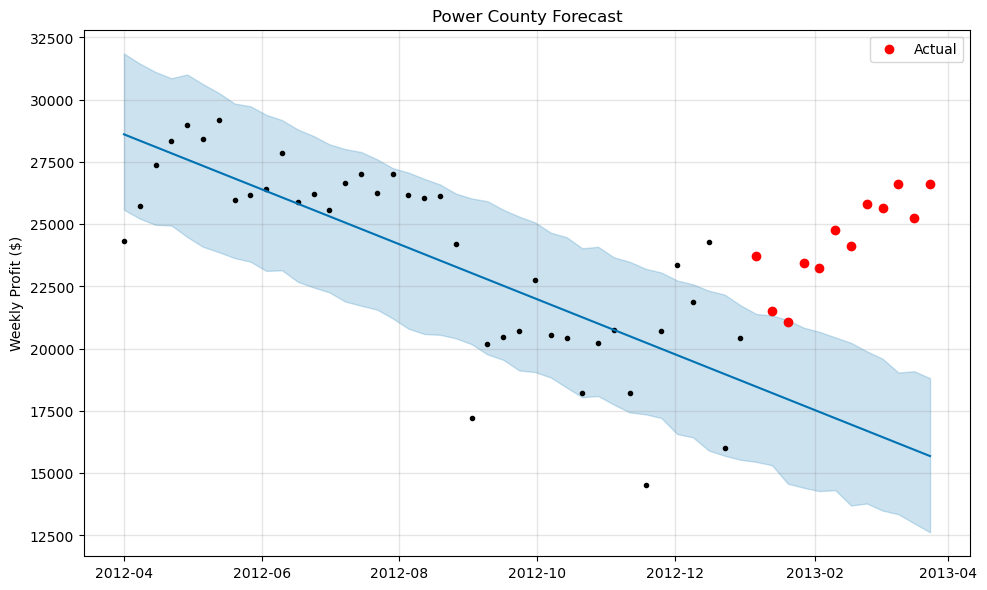

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


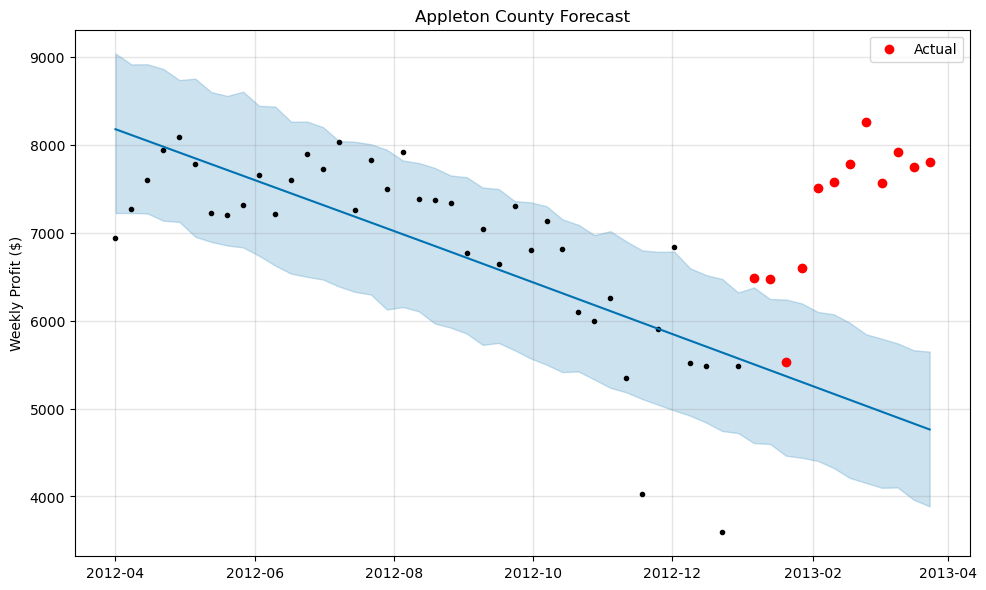

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


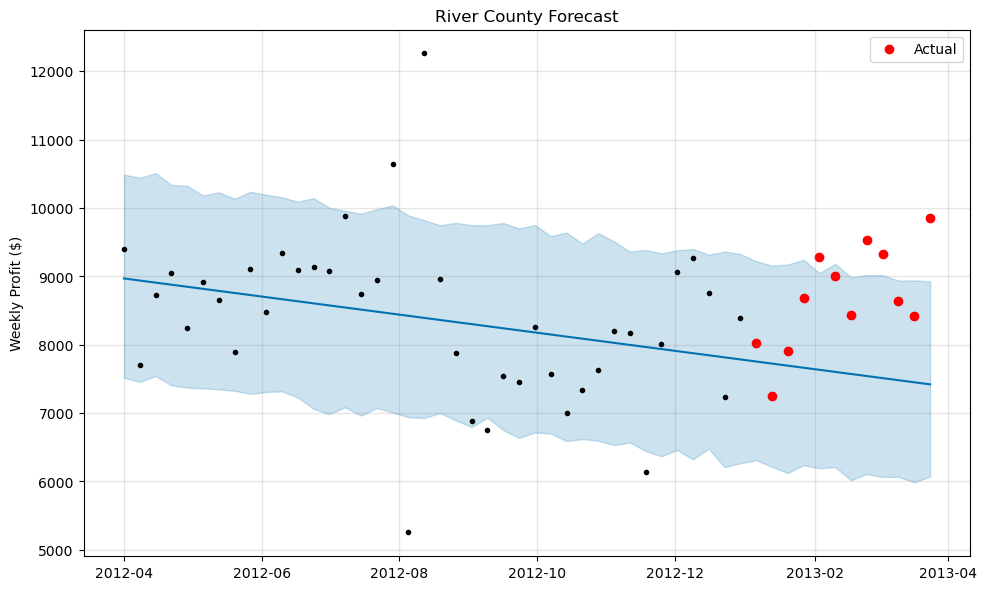

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


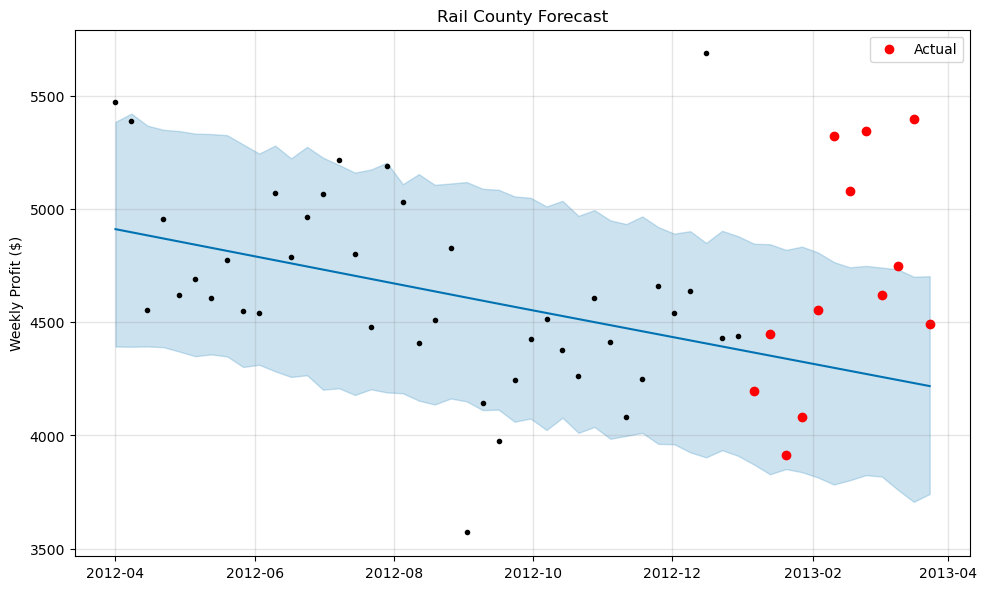

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


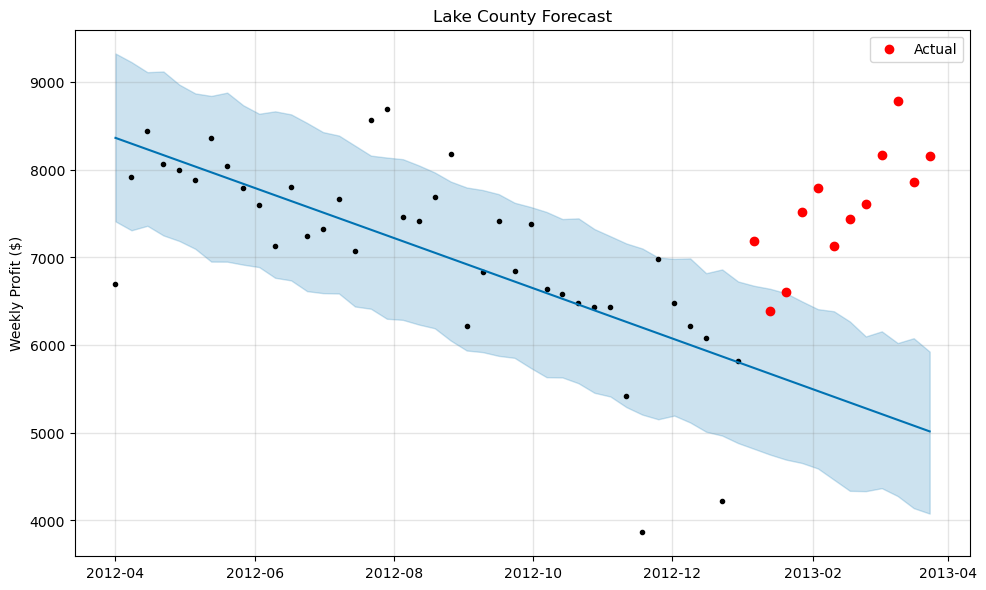

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


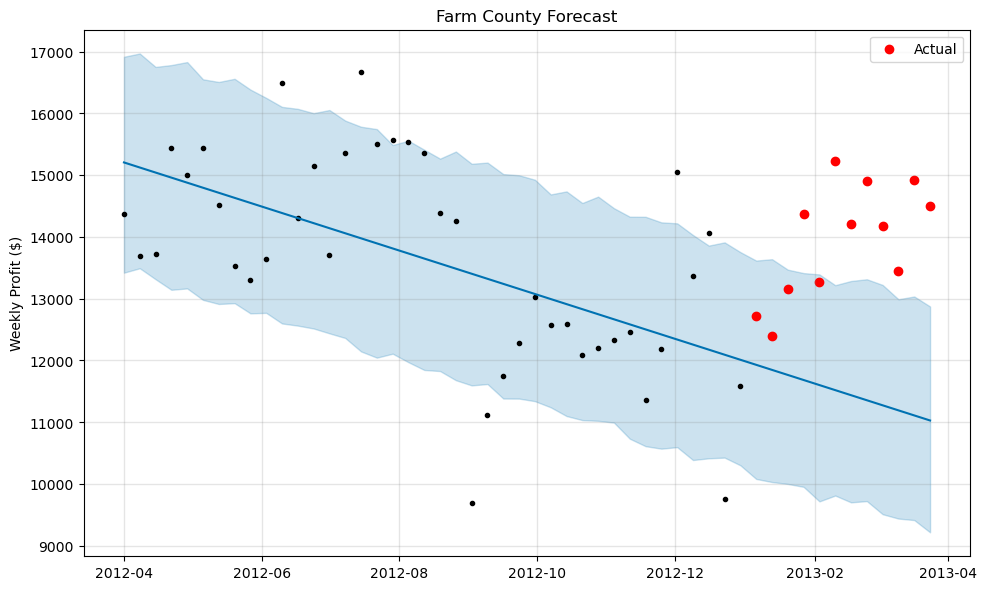

In [24]:
# Fitting the dfs to the Prophet models and creating graphs
counties_train = []
counties_test = []
counties_future = []
counties_forecast = []
for i in range(len(profit_summ_dfs)):
    temp_train = profit_summ_dfs[i][profit_summ_dfs[i].ds < '2013']
    temp_test = profit_summ_dfs[i][profit_summ_dfs[i].ds >= '2013']
    counties_train.append(temp_train)
    counties_test.append(temp_test)
    temp_model = Prophet()
    temp_model.fit(temp_train)
    temp_future = temp_model.make_future_dataframe(periods = 12, freq = 'W')
    counties_future.append(temp_future)
    temp_forecast = temp_model.predict(temp_future)
    counties_forecast.append(temp_forecast)
    fig, ax = plt.subplots(figsize = (10,6))
    fig = temp_model.plot(temp_forecast, ax = ax)
    ax.scatter(temp_test.ds,temp_test.y, color = 'red', label = 'Actual')
    ax.set_title(f'{county_names[i]} Forecast')
    ax.set_ylabel('Weekly Profit ($)')
    ax.set_xlabel('')
    plt.legend()
    plt.show()

In [25]:
################# Creating Bivariate Prophet models ##########################


# Adding the weather station to the profit dfs
profit_wCountyWeather = profit.merge(store[['Store_Num', 'Store_County', 'Store_Weather_Station']]
                                     , how = 'left'
                                     , left_on = 'Store_num'
                                     , right_on = 'Store_Num')

profit_wCountyWeather.drop(['Store_num','Store_Num'], axis = 1, inplace = True)


# Incorporating the weather data
weatherSummary = weather[['Weather_Station', 'Weather_Date', 'Weather_Bad_Weather_days']]

profit_wCountyWeather = profit_wCountyWeather.merge(weatherSummary
                                                    , how = 'left'
                                                    , left_on = ['Date', 'Store_Weather_Station']
                                                    , right_on = ['Weather_Date', 'Weather_Station'])

profit_wCountyWeather.drop(['Store_Weather_Station','Weather_Station','Weather_Date']
                           , axis = 1, inplace = True)


# Creating dfs to separate each county
powerCounty = profit_wCountyWeather[profit_wCountyWeather.Store_County == 'Power County']
appletonCounty = profit_wCountyWeather[profit_wCountyWeather.Store_County == 'Appleton County']
riverCounty = profit_wCountyWeather[profit_wCountyWeather.Store_County == 'River County']
railCounty = profit_wCountyWeather[profit_wCountyWeather.Store_County == 'Rail County']
lakeCounty = profit_wCountyWeather[profit_wCountyWeather.Store_County == 'Lake County']
farmCounty = profit_wCountyWeather[profit_wCountyWeather.Store_County == 'Farm County']

In [26]:
# Creating a list of the county dfs to loop through
county_dfs = [powerCounty, appletonCounty, riverCounty, railCounty, lakeCounty, farmCounty]

# Preparing the county dfs to be fit to the Prophet model
county_summ_dfs = []
for df in county_dfs:
    temp_df = df.drop(['Store_County'], axis = 1)
    temp_df = temp_df.groupby('Date').agg(Profit = ('Profit', 'sum'),
                                          Weather = ('Weather_Bad_Weather_days', np.mean))
    temp_df = temp_df.reset_index()
    temp_df = temp_df.rename(columns = {'Date':'ds',
                                        'Profit':'y',
                                        'Weather':'badWeatherDays'})
    county_summ_dfs.append(temp_df)


# Filling the Farm County NA value with a 0 (only one)
county_summ_dfs[5] = county_summ_dfs[5].fillna(0)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


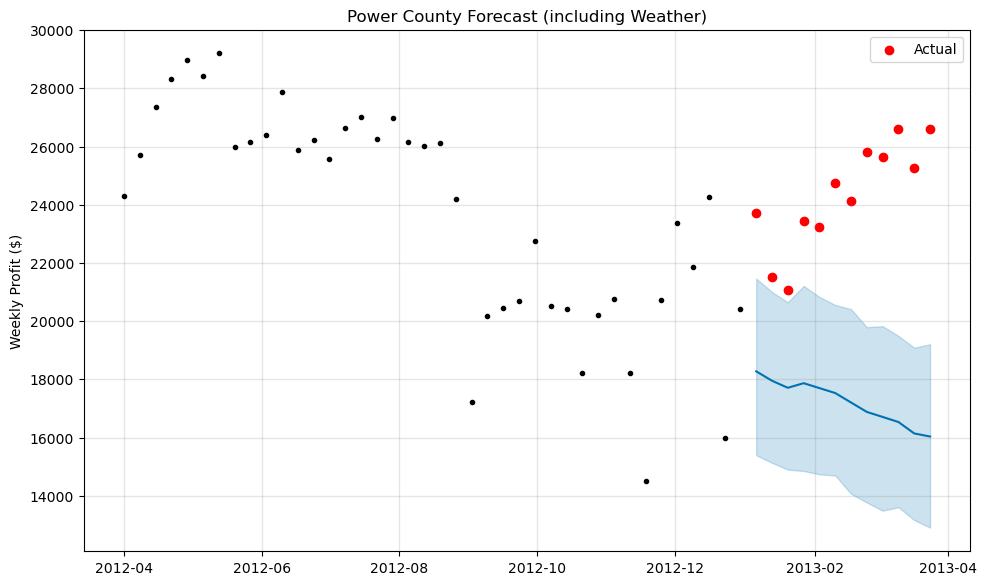

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


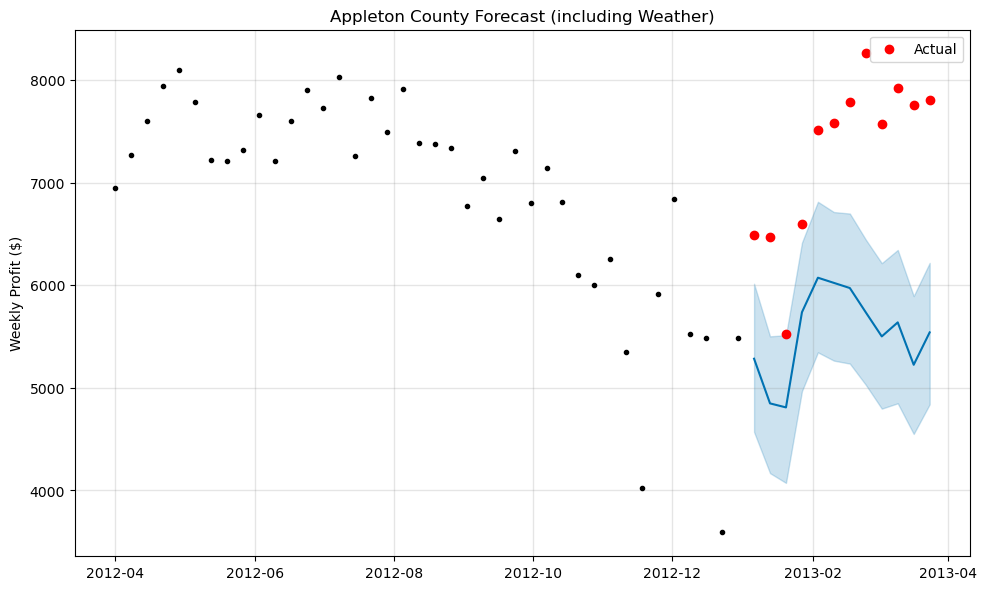

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


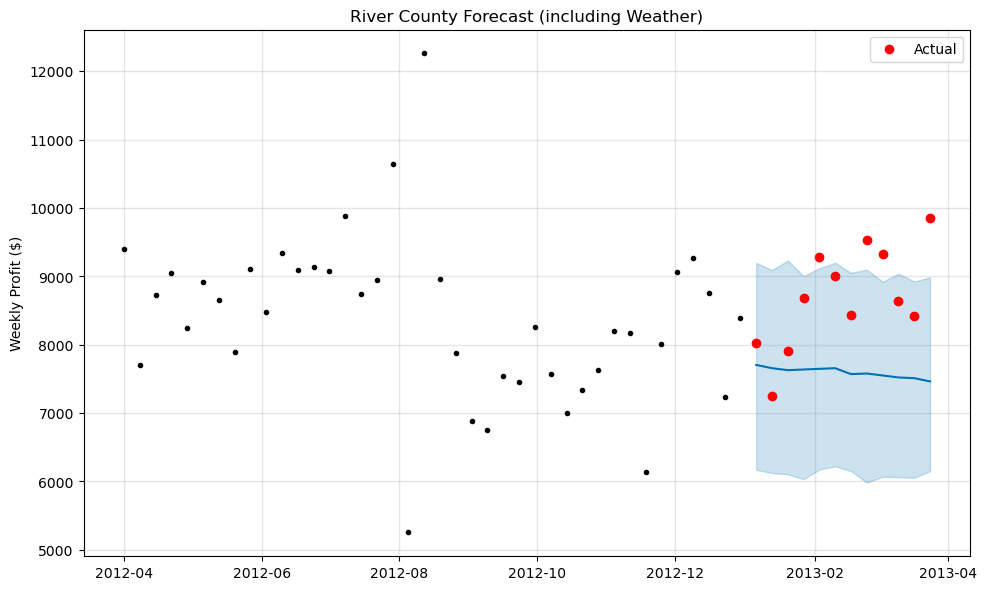

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


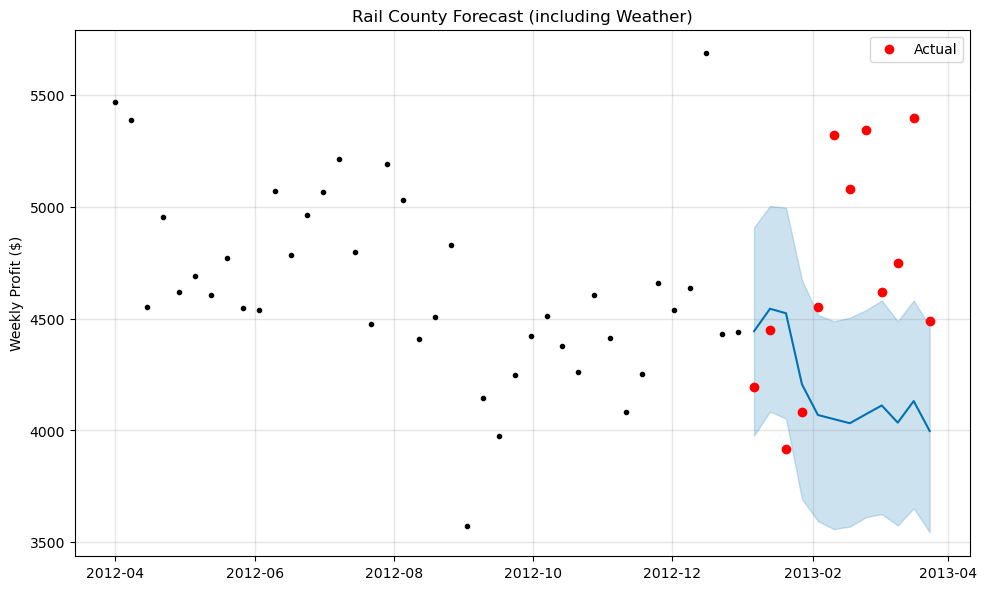

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


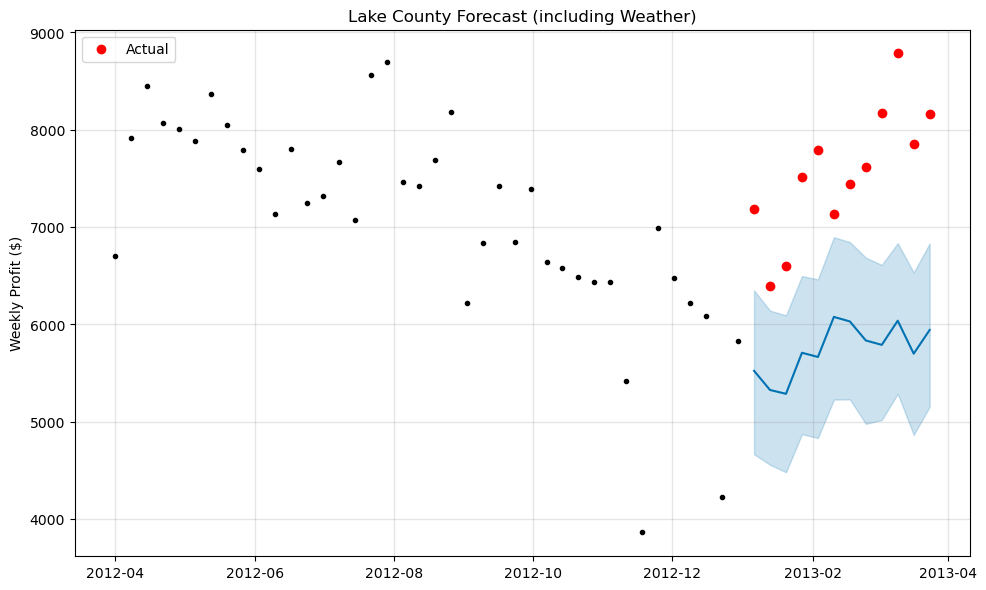

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


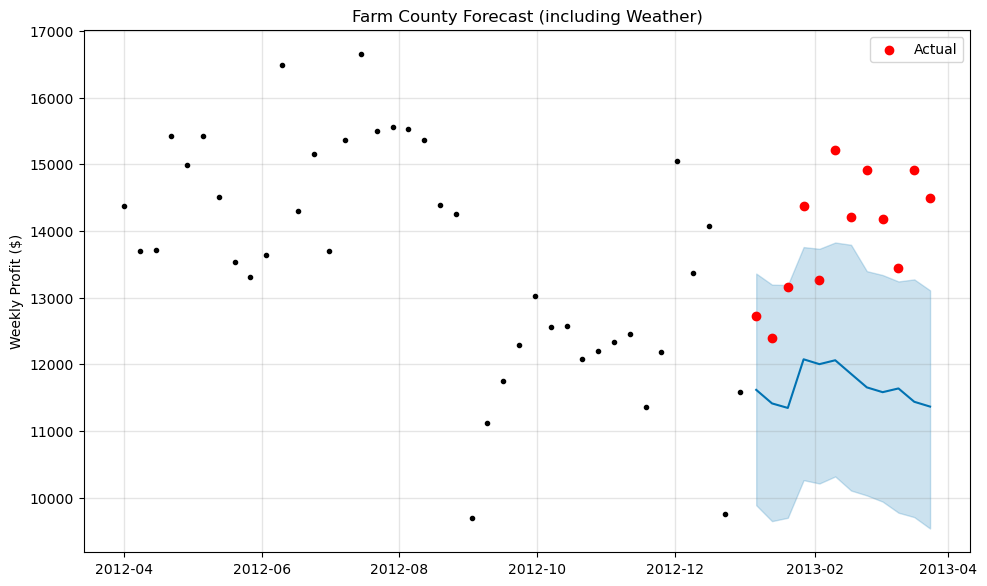

In [27]:
# Fitting the dfs to the Prophet models and creating graphs
countiesWeather_train = []
countiesWeather_test = []
countiesWeather_future = []
countiesWeather_forecast = []
for i in range(len(county_summ_dfs)):
    temp_train = county_summ_dfs[i][county_summ_dfs[i].ds < '2013']
    temp_test = county_summ_dfs[i][county_summ_dfs[i].ds >= '2013']
    countiesWeather_train.append(temp_train)
    countiesWeather_test.append(temp_test)
    temp_model = Prophet(seasonality_mode = 'multiplicative'
                         , weekly_seasonality = True)
    temp_model.add_regressor('badWeatherDays')
    temp_model.fit(temp_train)
    temp_future = temp_test.drop('y', axis = 1)
#    temp_future = temp_model.make_future_dataframe(periods = 12, freq = 'W')
    countiesWeather_future.append(temp_future)
    temp_forecast = temp_model.predict(temp_future)
    countiesWeather_forecast.append(temp_forecast)
    fig, ax = plt.subplots(figsize = (10,6))
    fig = temp_model.plot(temp_forecast, ax = ax)
    ax.scatter(temp_test.ds,temp_test.y, color = 'red', label = 'Actual')
    ax.set_title(f'{county_names[i]} Forecast (including Weather)')
    ax.set_ylabel('Weekly Profit ($)')
    ax.set_xlabel('')
    plt.legend()
    plt.show()